In [36]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt
from cvlib.object_detection import draw_bbox
import cvlib as cv
import math
import spacy
nlp = spacy.load("en_core_web_sm")

In [7]:
# Returns line of pointing direction
def resolve_pointing_direction(scene_image):
    """Given scene image containing a pointing right hand, this function returns the line of pointing direction
    Argument:
    scene_image -- binary data of scene image containing pointing hand
    Return value:
    List containing coordinates representing a line corresponding to pointing direction 
    of the hand in the scene image
    """
    
    img = np.copy(scene_image)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    upper = np.array([0, 0.35*255, 0])
    bottom = np.array([15, 0.75*255, 255])

    mask = cv2.inRange(img_hsv, upper, bottom)
    masked = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    blur = cv2.GaussianBlur(masked, (7, 7), 0)
    ret,thresh = cv2.threshold(blur,64,255,cv2.THRESH_BINARY)

    thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY);
    contours, hierarchy = cv2.findContours (thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    max_cnt = max (contours, key = lambda x: cv2.contourArea (x))
    cv2.drawContours(img, max_cnt, -1, (255,255,0), 2)

    M = cv2.moments(max_cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.circle(img, (int(cX), int(cY)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(img, "hand_C", (int(cX), int(cY)), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, lineType=cv2.LINE_AA)

    extTop = tuple(max_cnt[max_cnt[:, :, 1].argmin()][0])
    cv2.circle(img, extTop, 3, (255, 0, 0), -1, lineType=cv2.FILLED)
    cv2.putText(img, "fingertip", extTop, cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, lineType=cv2.LINE_AA)

    x_values = [extTop[0], cX]
    y_values = [extTop[1], cY]
    cv2.line(img, extTop, (cX, cY), 1, 3)

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
#     cv2.imwrite("test.jpg",img)

    x2, y2 = extTop
    x1, y1 = (cX, cY)
    '''
    TODO: You should implement code to get proper value of gradient and intercept 
    to replace assignments of mock values below.
    '''
    gradient=(y2-y1)/(x2-x1)
    intercept= y2 - gradient*(x2)
    
    return [gradient, intercept]

In [370]:
fname = 'scene_image_train/scene_image_03.JPG'

scene_image = cv2.imread(fname)
img = np.copy(scene_image)

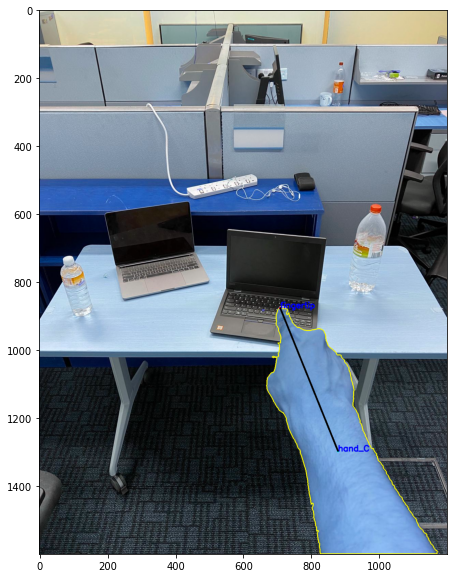

In [371]:
gradient, intercept = resolve_pointing_direction(scene_image)

In [372]:
bbox, label, conf = cv.detect_common_objects(img)
img = draw_bbox(img, bbox, label, conf)
detected_objects = list(zip(label, bbox))
detected_objects = [x for x in detected_objects if x[0]!="person"]

In [373]:
centroid_l = []
for obj_name, coordinate in detected_objects:
    x = (coordinate[0]+coordinate[2])/2
    y = (coordinate[1]+coordinate[3])/2
    centroid = (int(x),int(y))
    centroid_l.append((obj_name, centroid, coordinate))

In [374]:
centroid_l

[('laptop', (670, 807), [498, 634, 843, 981]),
 ('bottle', (965, 700), [909, 566, 1021, 835]),
 ('laptop', (346, 704), [193, 568, 500, 840]),
 ('bottle', (112, 811), [65, 721, 159, 902]),
 ('cell phone', (779, 504), [749, 475, 810, 533]),
 ('remote', (540, 515), [433, 479, 647, 552]),
 ('bottle', (882, 208), [863, 147, 901, 269])]

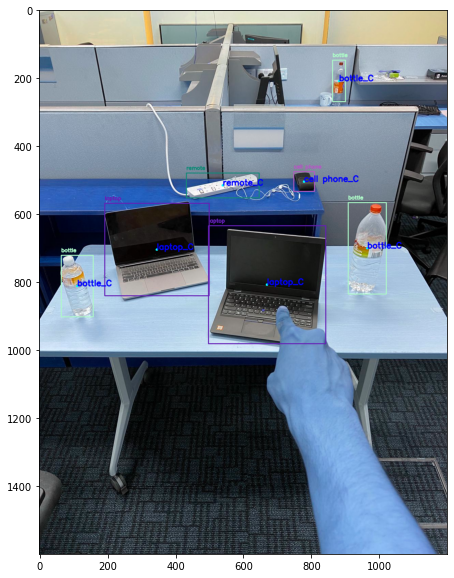

In [375]:
for obj_name, centroid, coordinate in centroid_l:
    cv2.circle(img, centroid, 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(img, f"{obj_name}_C", centroid, cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, lineType=cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [376]:
#ax + by + c = 0
# y = mx + b
# -mx + y - c = 0
#x1, y1

distance_l = []
for obj_name, centroid, coordinate in centroid_l:
    x1 = centroid[0]
    y1 = centroid[1]
    d = abs((-gradient * x1 + 1 * y1 - intercept)) / (math.sqrt((-gradient) * (-gradient) + 1 * 1))
    
    distance_l.append((obj_name, d, coordinate))
distance_l = sorted(distance_l, key=lambda tup: tup[1])

In [377]:
if len(distance_l) > 3:
    distance_l = distance_l[0:3]

In [378]:
distance_l

[('laptop', 10.327567531487762, [498, 634, 843, 981]),
 ('remote', 21.538341414036815, [433, 479, 647, 552]),
 ('cell phone', 204.19466535385476, [749, 475, 810, 533])]

In [379]:
command_text = "select that bottle"

In [380]:
doc = nlp(command_text)
obj_l = []
obj_l = [token.text for token in doc if token.dep_ == "dobj"]
if len(obj_l) == 0:
    obj_l = [token.text for token in doc if token.tag_ == "NN"]

In [381]:
obj_l

['bottle']

In [382]:
temp_l = []

# check if there is an object that match the extracted obj from command text
for obj_name, dist, coordinate in (distance_l):
    obj_name_l = obj_name.split()
    for token in obj_name_l: 
        if token in obj_l:
            temp_l.append((obj_name, dist, coordinate))
            break


if len(temp_l) == 0:
    obj_out = min(distance_l, key=lambda tup: tup[1])
    obj_out = (obj_out[0], obj_out[-1])
# if there are multiple object that match, choose the object with the least distance

elif len(temp_l) != 1:
    obj_out = min(temp_l, key=lambda tup: tup[1])
    obj_out = (obj_out[0], obj_out[-1])

else:
    obj_out = (temp_l[0])
    obj_out = (obj_out[0], obj_out[-1])

In [383]:
obj_out

('laptop', [498, 634, 843, 981])

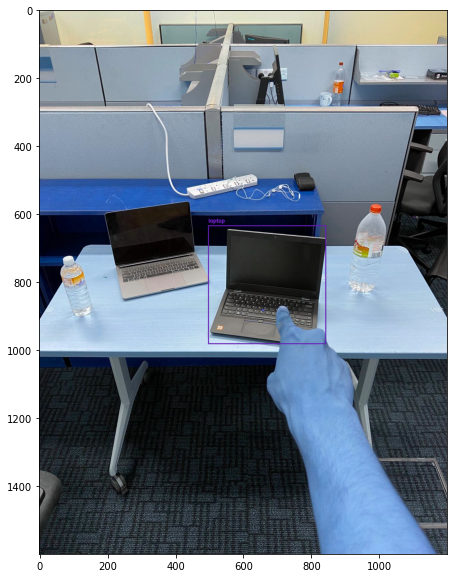

In [384]:
img = np.copy(scene_image)

for i, coordinate in enumerate(bbox):
    if coordinate == obj_out[1]:
        bbox_filtered = [coordinate]
        label_filtered = [label[i]]
        conf_filtered = [conf[i]]
        break


img = draw_bbox(img, bbox_filtered, label_filtered, conf_filtered)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()